<a href="https://colab.research.google.com/github/pabloisaiahs/DS-4002-proj2-MI3/blob/main/SCRIPTS/forecasting_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Head of the dataset:
   Unnamed: 0       Date President  Approval PrezParty Chamber ChamberParty  \
0           1 1945-06-01    Truman      87.0  Democrat     NaN          NaN   
1           2 1945-10-01    Truman      82.0  Democrat     NaN          NaN   
2           3 1945-11-01    Truman      75.0  Democrat     NaN          NaN   
3           4 1946-01-01    Truman      63.0  Democrat     NaN          NaN   
4           5 1946-02-01    Truman      49.0  Democrat     NaN          NaN   

   UnemploymentRate  GDP  
0               NaN  NaN  
1               NaN  NaN  
2               NaN  NaN  
3               NaN  NaN  
4               NaN  NaN  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        883 non-null    int64         
 1   Date              883 non-null    datetime64[ns]
 2   Pr

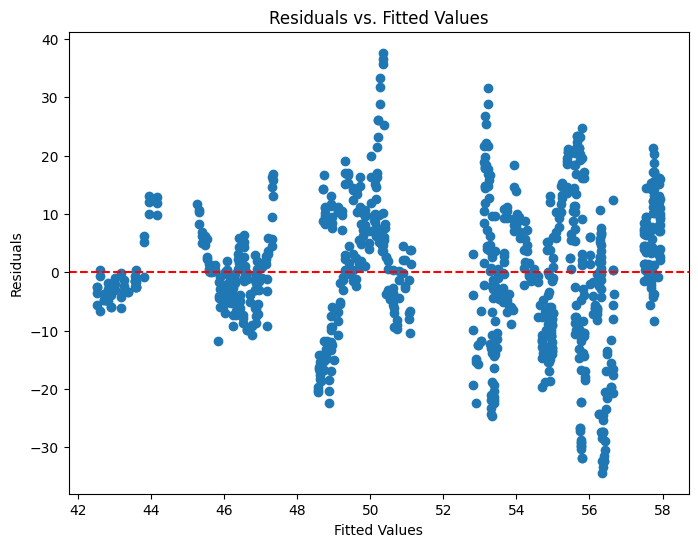

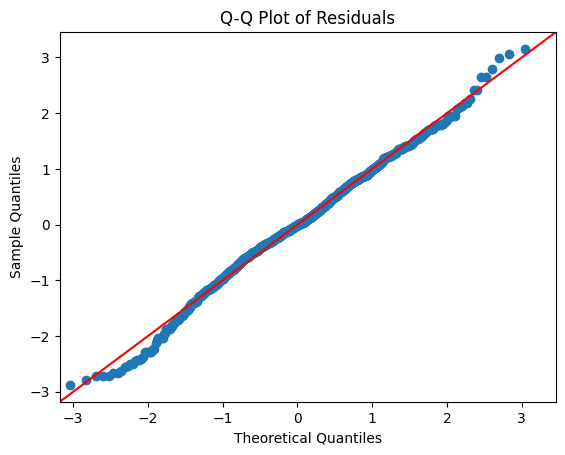

In [3]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ---------------------------
# 1. Data Loading and Preparation
# ---------------------------
# Load the inferred dataset (monthly GDP values inferred from quarterly data)
data = pd.read_csv("allDataInferredGDP.csv")

# Convert the Date column to datetime.
# Our dates are in the format "YYYY/MM" (e.g., "1945/06")
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m", errors='coerce')

# Inspect the data
print("Head of the dataset:")
print(data.head())
print("\nDataset info:")
print(data.info())

# For regression, we'll use the following columns:
# - Approval (dependent variable)
# - GDP (predictor)
# - UnemploymentRate (predictor)
# - PrezParty (predictor; categorical)
# Remove rows where any of these values are missing.
reg_data = data.dropna(subset=['Approval', 'GDP', 'UnemploymentRate', 'PrezParty'])
print("\nNumber of observations after dropping missing values:", reg_data.shape[0])

# ---------------------------
# 2. Fit the Full Regression Model
# ---------------------------
# Specify the full regression model. Here, we treat PrezParty as a categorical variable.
formula_full = "Approval ~ GDP + UnemploymentRate + C(PrezParty)"

# Fit the full model using ordinary least squares (OLS)
full_model = smf.ols(formula=formula_full, data=reg_data).fit()
print("\nFull Model Summary:")
print(full_model.summary())

# ---------------------------
# 3. Backward Elimination (Stepwise Regression)
# ---------------------------
def backward_elimination(data, response, predictors, significance_level=0.05):
    """
    Iteratively remove predictors with p-values > significance_level.
    Returns the final model and list of predictors that remain.
    """
    import copy
    remaining_predictors = copy.deepcopy(predictors)
    while len(remaining_predictors) > 0:
        formula = response + " ~ " + " + ".join(remaining_predictors)
        model = smf.ols(formula, data=data).fit()
        # Exclude the intercept's p-value
        pvalues = model.pvalues.drop('Intercept')
        max_pval = pvalues.max()
        if max_pval > significance_level:
            predictor_to_remove = pvalues.idxmax()
            print(f"Removing {predictor_to_remove} with p-value {max_pval:.4f}")
            remaining_predictors.remove(predictor_to_remove)
        else:
            break
    final_formula = response + " ~ " + " + ".join(remaining_predictors)
    final_model = smf.ols(final_formula, data=data).fit()
    return final_model, remaining_predictors

# Define the initial list of predictors. For categorical variables, include the factor notation.
predictors = ["GDP", "UnemploymentRate", "C(PrezParty)"]

final_model, selected_predictors = backward_elimination(reg_data, "Approval", predictors)
print("\nFinal Model Summary after Backward Elimination:")
print(final_model.summary())

# ---------------------------
# 4. Regression Diagnostics
# ---------------------------
# Residuals vs. Fitted Values Plot
plt.figure(figsize=(8,6))
plt.scatter(final_model.fittedvalues, final_model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Q-Q Plot for normality of residuals
fig = sm.qqplot(final_model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()
